---
title: "Image Recognition with a Convolutional Neural Network"
date: "2018-05-05"
path: "/image-recognition-with-a-convolutional-neural-network/"
category: "Projects"
thumbnail: "thumbnail.jpg"
---

In this write up I will be developing a Convolutional Neural Network to do image recognition. I will be working with the CIFAR-10 dataset. This is a very popular image dataset for developing and testing Machine Learning algorithms due to image size and data quality; training a model with variations in optimization parameters or architectures can happen much more quickly, while still being applicable to image related challenges. This dataset size and structure also be transferable to real world datasets of images where the image sizes are not very large. An example could be segmented photos of lung modules or small features of larger images that were curated into a dataset for classification tasks.

In this secenary, the hypothetical client has given me a repository of images and they ask if I can build a model that will correctly recognize a series of classes from a bunch of images. My assumption here is that this request can be predicted, and that there is sufficient data to make this prediction:

_Hypothesis 1:_
 - There is a statistical probability relating the outputs to the inputs (I can beat random).
 
_Hypothesis 2:_
 - There is sufficient data to learn the relationships between the inputs and the outputs.
 
To test this, I will take a quick look at the data, build a base line model, and see if I can apply training tricks, statistical techniques and architectures in the hopes that I will have a powerful prediction engine.

In [1]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
from keras import optimizers
import keras.backend as K
import pickle
import itertools

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Load dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Peek at some samples

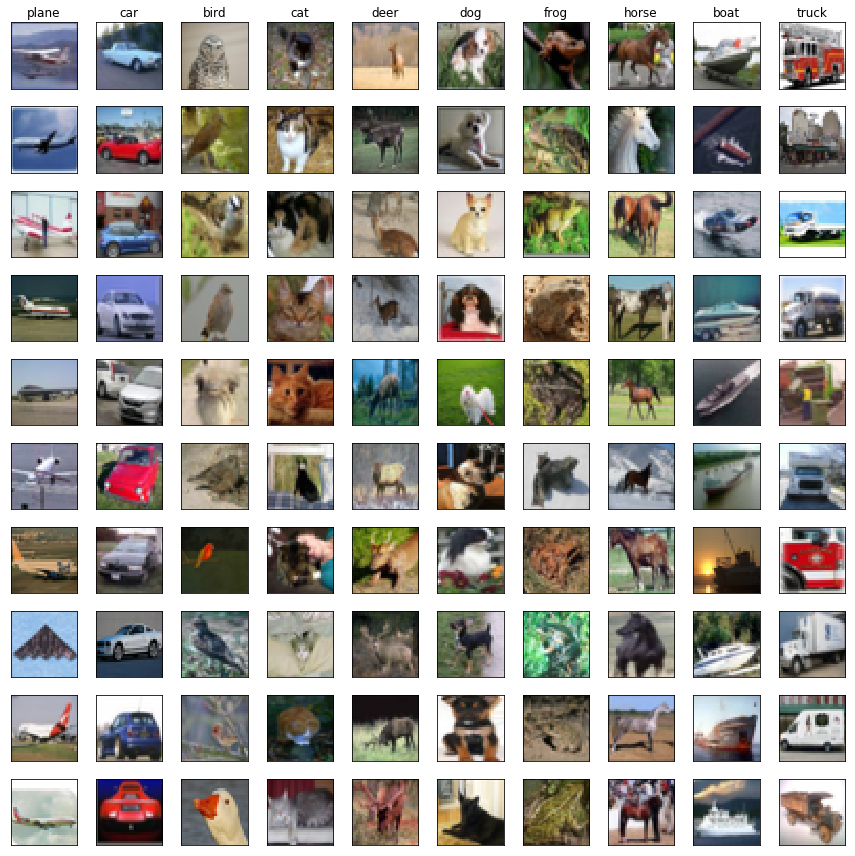

In [5]:
label = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

rows, cols = 10, 10
def plot_samples(x_train, y_train, rows, cols):
    
    fig = plt.figure(figsize=(12,12))
    g_s = gridspec.GridSpec(rows, cols)
    # g_s.update(left=0.1,right=0.9,wspace=0.05, top=0.9, bottom=0.1)
    ax = {}
    
    for i in range(cols):
        sample_pics = x_train[(y_train == i).reshape(-1)]
        for j in range(rows):
            num_samples = sample_pics.shape[0]
            random_idx = np.random.choice(num_samples, replace=False) 
            sample_pic = x_train[(y_train == i).reshape(-1)][random_idx]

            ax[(i, j)] = fig.add_subplot(g_s[j, i])
            ax[(i, j)].set_xticks([])
            ax[(i, j)].set_yticks([])
            ax[(i, j)].imshow(sample_pic)
        ax[(i, 0)].set_title(label[i])
    fig.tight_layout()
plot_samples(x_train, y_train, rows, cols);

### Observations
- Some images are not completely centered (padding and sub-sampling might help)
- Background color is diverse within subgroups (model may not train on color scheme of photos?)
- The entire object is contained in each image (easier time for recognition)
- the images are all the same size (no cropping, padding or subsampling necessary)
- there is a perfect distribution of classes (oversampling not necessary)

### Creating Data Splits: Validation Sets
First let's create a validation set from the training set. It's good practice to train your model on one set of data, then improve the accuracy and tune hyper-parameters by measuring against a validation set. After all the fine-tuning is done, the final predictive capabilities of the model should be on a set of data that it has never seen before. There is a possibility that in the process of tuning the hyper-parameters, the model has over-fitted to the validation data, so a good judge of generalization is to measure against the test dataset.

In [4]:
print('Current Data Shape:'
      '\n\tX(train): {}'
      '\n\tY(train): {}'
      '\n\tX(test): {}'
      '\n\tY(test): {}'.format(x_train.shape[0],
                               y_train.shape[0],
                               x_test.shape[0],
                               y_test.shape[0]))

def shuffle_split(x, y, split=0.8):
    samples = x.shape[0]
    shuffle = np.random.choice(samples, samples)
    x = x[shuffle]
    y = y[shuffle]
    split_idx = int(samples * split)
    x_train = x[:split_idx]
    y_train = y[:split_idx]
    x_valid = x[split_idx:]
    y_valid = y[split_idx:]
    
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = shuffle_split(x_train, y_train)

print('Split Data Shape:'
      '\n\tX(train): {}'
      '\n\tY(train): {}'
      '\n\tX(valid): {}'
      '\n\tY(valid): {}'.format(x_train.shape[0],
                               y_train.shape[0],
                               x_valid.shape[0],
                               y_valid.shape[0]))


Current Data Shape:
	X(train): 50000
	Y(train): 50000
	X(test): 10000
	Y(test): 10000
Split Data Shape:
	X(train): 40000
	Y(train): 40000
	X(valid): 10000
	Y(valid): 10000


### Pre-Processing the Data
Generally Machine Learning models like normalized data. That way no single feature over powers other features because of the magnitude of scale. Image data is technically of the same scale (all values exist between 0-255), but it's best to have the values centered about zero and with a standard deviation of 1. This helps control the weight values and generally allows the model to train properly.

Another technique employed is random horizontal flipping. This data augmentation technique randomly flips the images, creating unique perspectives of the same object. This can lead to better predictive capabilities.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Data metadata
num_classes = 10
in_dim = x_train.shape[1:]

# Normalize data; create preprocessing function
data = ImageDataGenerator(samplewise_center=True, 
                          samplewise_std_normalization=True,
                          horizontal_flip=True)
data.fit(x_train)

# Convert y_train to one hot encoding of classes(num_examples x num_classes)
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

# TODO:
# Add Data Augmentation
# Add padding: Add pixels around image and pick 32x32 not centered crops

### Simple Deep Convolutional Neural Network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

# hyper parameters:
p = 0.25  # Dropout probability 
k = 3     # kernel size for convolution
f1 = 32   # number of filters, convolution 1
f2 = 64   # number of filters, convolution 2

model = Sequential(
        [Conv2D(f1, (k, k), padding='same', name='First-Convolution', input_shape=in_dim),
         Activation('relu', name='First-Relu'),
         Conv2D(f1, (k, k), padding='same', name='Second-Convolution'),
         Activation('relu', name='Second-Relu'),
         MaxPooling2D((2, 2), name='First-Max-Pool'),
         Dropout(p, name='First-Dropout'),
         Conv2D(f2, (k, k), padding='same', name='Third-Convolution'),
         Activation('relu', name='Third-Relu'),
         Conv2D(f2, (k, k), padding='same', name='Fourth-Convolution'),
         Activation('relu', name='Fourth-Relu'),
         MaxPooling2D((2, 2), name='Second-Max-Pool'),
         Dropout(p, name='Second-Dropout'),
         Flatten(name='Flatten'),
         Dense(512, name='First-Affine'),
         Activation('relu', name='Fifth-Relu'),
         Dropout(2*p, name='Third-Dropout'),
         Dense(10, name='Final-Connected-Layer'),
         Activation('softmax', name='Softmax')
        ])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First-Convolution (Conv2D)   (None, 32, 32, 32)        896       
_________________________________________________________________
First-Relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
Second-Convolution (Conv2D)  (None, 32, 32, 32)        9248      
_________________________________________________________________
Second-Relu (Activation)     (None, 32, 32, 32)        0         
_________________________________________________________________
First-Max-Pool (MaxPooling2D (None, 16, 16, 32)        0         
_________________________________________________________________
First-Dropout (Dropout)      (None, 16, 16, 32)        0         
_________________________________________________________________
Third-Convolution (Conv2D)   (None, 16, 16, 64)        18496     
__________

### Model Architecture

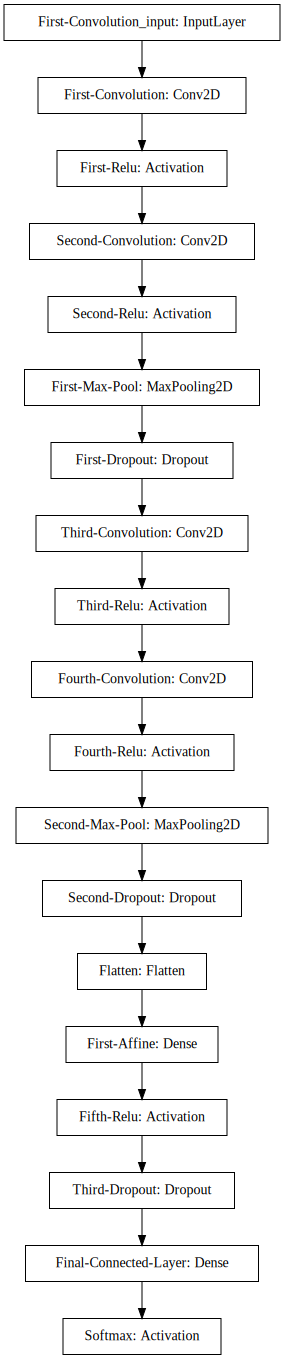

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Compile and Train a Base Model

In [13]:
base_model = model

# Iterations
num_train = x_train.shape[0]
num_epochs = 300
batch_size = 500
iters_per_epoch = num_train // batch_size

base_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.SGD(lr=0.001), 
                   metrics=['categorical_accuracy'])

# Flow training data through pre-processing pipeline
train_datagen = data.flow(x_train, y_train, batch_size=batch_size)
valid_datagen = data.flow(x_valid, y_valid, batch_size=batch_size)
test_datagen = data.flow(x_test, batch_size=batch_size)

# Fit the model
hist = base_model.fit_generator(train_datagen,
                                epochs=num_epochs,
                                validation_data=valid_datagen,
                                shuffle=True)

y_pred = base_model.predict_generator(test_datagen)

Epoch 1/300
80/80 [==============================] - 9s 108ms/step - loss: 2.3291 - categorical_accuracy: 0.1034 - val_loss: 2.2949 - val_categorical_accuracy: 0.1276
Epoch 2/300
80/80 [==============================] - 8s 102ms/step - loss: 2.3160 - categorical_accuracy: 0.1079 - val_loss: 2.2882 - val_categorical_accuracy: 0.1490
Epoch 3/300
80/80 [==============================] - 8s 103ms/step - loss: 2.3052 - categorical_accuracy: 0.1160 - val_loss: 2.2815 - val_categorical_accuracy: 0.1717
Epoch 4/300
80/80 [==============================] - 8s 102ms/step - loss: 2.2968 - categorical_accuracy: 0.1230 - val_loss: 2.2756 - val_categorical_accuracy: 0.1844
Epoch 5/300
80/80 [==============================] - 8s 103ms/step - loss: 2.2898 - categorical_accuracy: 0.1266 - val_loss: 2.2687 - val_categorical_accuracy: 0.1992
Epoch 6/300
80/80 [==============================] - 8s 103ms/step - loss: 2.2841 - categorical_accuracy: 0.1340 - val_loss: 2.2615 - val_categorical_accuracy: 0.217

### Save Model
I'm going to save the model so when I revisit the algorithm development, I don't need to retrain a base model for comparison.

In [17]:
import pickle

# serialize model to JSON
model_json = model.to_json()
with open("base_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("base_model.h5")
print("Saved model to disk")

model.save('base_model_all.h5')

# pickle the history
with open('base_model_history.pickle', 'wb') as handle:
    pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saved model to disk


As you can see in the plot to the right, it is not too clear on where the valley is with the learning rate and loss value. Well, that's machine learning for you. In an update to this post I will do some troubleshooting and look over this further, but the best I can ascertain from the visualization as it stands is a good initial learning rate would be in the $10^{-3}$ range, as it looks like theres a dip right at the $10^{-2}$.

### Load Model, Assess Training

In [8]:
import pickle
from keras.models import model_from_json

base_model = model

# load weights into new model
base_model.load_weights("base_model.h5")
print("Loaded model from disk")

# Load history
with open('base_model_history.pickle', 'rb') as handle:
    history = pickle.load(handle)

Loaded model from disk


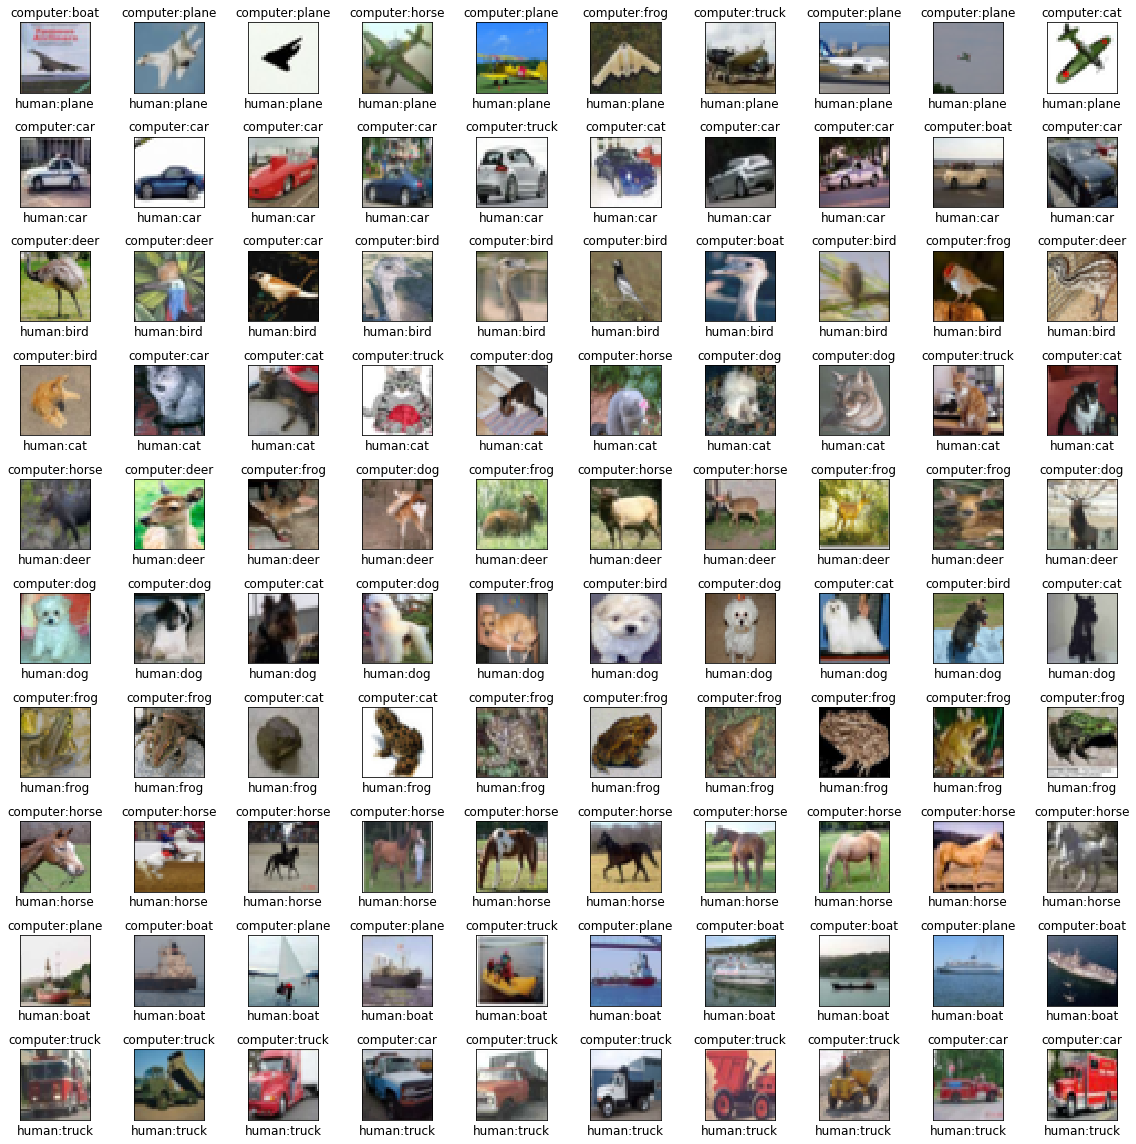

In [14]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
labels = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

fig, axs = plt.subplots(10, 10, figsize=(16, 16))

count = 0
k = 0
l = 0
z = 0

x_test_normalized = data.standardize(x_test.astype('float32'))

while count < 100:
    if z> 9:
        z = 0
        l += 1
    i = count // 10
    j = count % 10
    ground_truth = y_test[k].argmax()
    if ground_truth == l:
        prediction = base_model.predict(x_test_normalized[k][np.newaxis,:]).argmax()
        axs[i, j].imshow(x_test[k])
        axs[i, j].set_title('computer:' + labels[prediction], size=12)
        axs[i, j].set_xlabel('human:' + labels[ground_truth], size=12)
        axs[i, j].set_xticks([]), axs[i,j].set_yticks([])
        count += 1
        z += 1
    k += 1
    
fig.tight_layout()

## Creating Metrics for Base Model
I want to take a look at the loss, the accuracy, a confusion matrix and a few samples of mis-classified images to try to get an idea of how the model is performing.

In [33]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    
def dashboard(history, cm, labels, y_pred=None, test_data=None):
    """
    Creates a dashboard of the data
    """
    assert len(y_pred.shape) == 1, "y_pred must be a 1D array of truth values"
    
    fig = plt.figure(figsize=(15,10))
    grid = gridspec.GridSpec(2, 6)
    
    ax = []
    
    ax += [fig.add_subplot(grid[0, :2])]
    ax[0].set_title('Loss over Training Epochs')
    ax[0].plot(history['loss'])
    ax[0].plot(history['val_loss'])
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0, 2:4])]
    ax[1].set_title('Categorical Accuracy')
    ax[1].plot(history['categorical_accuracy'])
    ax[1].plot(history['val_categorical_accuracy'])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0, 4:6])]
    ax[2].set_title('Confusion Matrix')
    plot_confusion_matrix(cm, labels, ax=ax[2], normalize=True)
    
    grid.update(hspace=0)
    if not y_pred is None:
        x_test, y_test = test_data
        
        imgs = x_test[y_test != y_pred]
        lbls = y_test[y_test != y_pred]
        
        num_samples = len(lbls) if len(lbls) < 6 else 6
        
        # choose random images
        idxs = np.random.choice(imgs.shape[0], num_samples)
        for i in range(num_samples):
            ax += [fig.add_subplot(grid[1,i])]
            ax[3+i].imshow(x_test[idxs[i]])
            ax[3+i].text(s=labels[y_pred[i]], x=0.5, y=-0.5, weight='bold', size='14')
            ax[3+i].axis('off')
            
    fig.tight_layout()

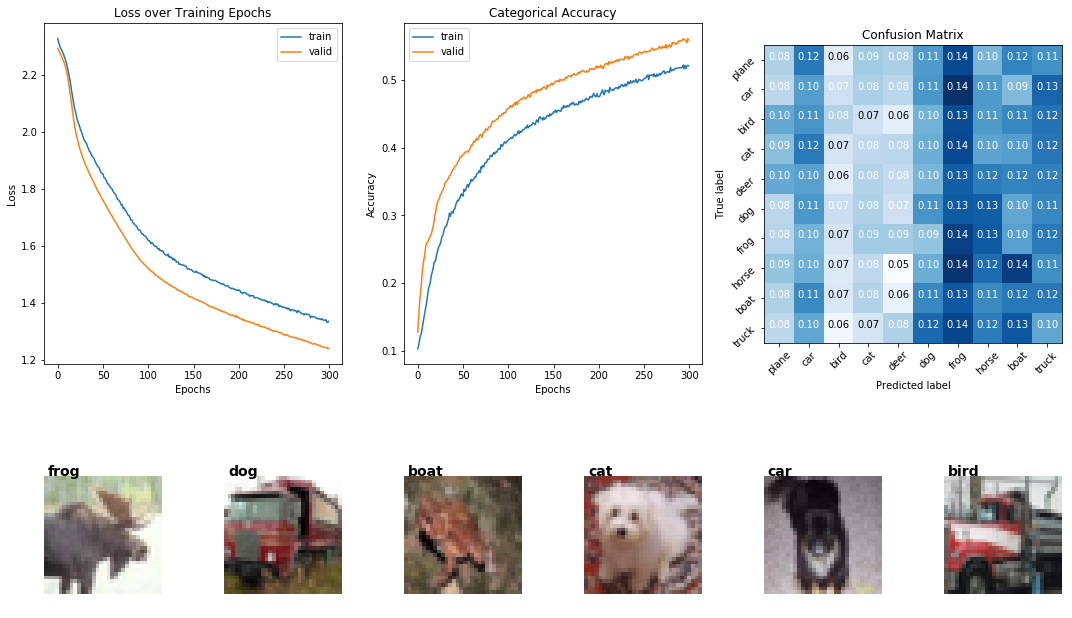

In [59]:
labels = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

class_names = list(labels.values())

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
dashboard(history, cm=cnf_matrix, labels=class_names, y_pred=y_pred.argmax(1), test_data=(x_test, y_test.argmax(1)))

### Observations
It doesn't look like the model trained long enough. The Loss never quite flattened out, and the accuracy still seemed like it had room to improve. One option here is to train longer or get more data (using data augmentation techniques), but I'm going to first try to optimize the learning rate so that I spend less time (and computational power) training the model. 

From the confusion matrix, it seems like it just mis-classifies across the board. There are no particular hot spots where certain classes are misclassified way more than others -- which makes sense because the dataset has an even representation of all classes which are all centered. Ideally I'd like to see a deep dark blue line diagonally across the heat map (all predictions matched the equivalent ground truth) and all else white, but will have to keep fine tuning and improvising to get there!

### Improving Model: Learning Rate Scheduling and Optimizers

One cool technique for optimizing the learning rate is the idea of cycling the learning rate values -- increasing the learning rate (instead of decaying it) in a cyclical fashion as a means of helping the model hop out of local minimums and continue gradient descent to the best possible minima. Below is a callback implementation of the algorithm presented in the arXiv paper: https://arxiv.org/abs/1506.01186

The general algorithm is to start at a minimum learning rate, increasing in a linear, exponential or geometric fashion at each iteration until reaching the maximum learning rate, then resetting back down to the minimum learning rate. The rate of change of increase in the learning rate should generally happen over 2 - 8 epochs.

To figure out the lowest and highest learning rate, the author suggests starting at a very low learning rate and begin increasing until the model starts to converge (when it does, that will be your lowest learning rate), and when the convergence (the models increase in accuracy) begins to slow, that will be your highest learning rate setting.

In [15]:
from CustomCallback import CyclicLR

# parameter settings
num_train = x_train.shape[0]
num_epochs = 50
batch_size = 500
iters_per_epoch = num_train // batch_size

# Learning rate Scheduler -- space out the increasing LR to match total iterations
clr = CyclicLR(base_lr=0.001, 
               max_lr=0.1, 
               step_size=num_epochs * iters_per_epoch, 
               mode='triangular')

lr_finder = model

# build model with SGD optimizer
lr_finder.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.SGD(lr=0.0001), 
                  metrics=['categorical_accuracy'])

# Flow training data through pre-processing pipeline
train_datagen = data.flow(x_train, y_train, batch_size=batch_size)
valid_datagen = data.flow(x_valid, y_valid, batch_size=batch_size)
test_datagen = data.flow(x_test, batch_size=batch_size)

# Fit the model
hist = lr_finder.fit_generator(train_datagen,
                                epochs=num_epochs,
                                validation_data=valid_datagen,
                                callbacks=[clr],
                                shuffle=True,
                                verbose=0)


Text(0,0.5,'Accuracy')

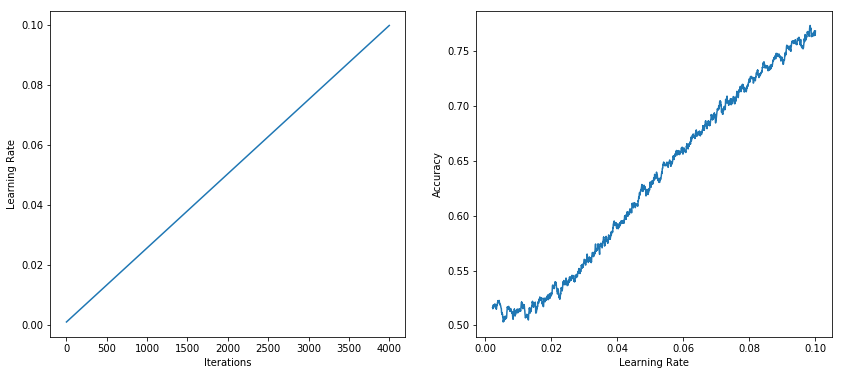

In [16]:
# For smoothing out learning history
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(clr.history['iterations'], clr.history['lr'])
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Learning Rate')

ax[1].plot(clr.history['lr'][49:], moving_average(clr.history['categorical_accuracy']))
ax[1].set_xlabel('Learning Rate')
ax[1].set_ylabel('Accuracy')                    

So, the model never stopped converging... perhaps the max Learning Rate can be set even higher. I'm going to continue training for a couple more epochs and see if I can get it to a point where the accuracy improvement slows down.

Text(0,0.5,'Accuracy')

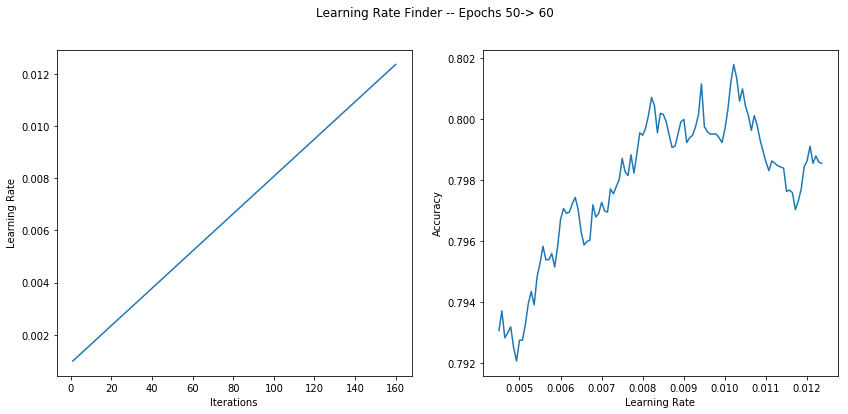

In [19]:
num_epochs = 2
batch_size = 500
iters_per_epoch = num_train // batch_size

# Learning rate Scheduler -- space out the increasing LR to match total iterations
clr = CyclicLR(base_lr=0.001, 
               max_lr=0.02, 
               step_size=num_epochs * iters_per_epoch, 
               mode='triangular')

# Fit the model
hist = lr_finder.fit_generator(train_datagen,
                                epochs=num_epochs,
                                validation_data=valid_datagen,
                                callbacks=[clr],
                                shuffle=True,
                                verbose=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Learning Rate Finder -- Epochs 50-> 60')
ax[0].plot(clr.history['iterations'], clr.history['lr'])
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Learning Rate')

ax[1].plot(clr.history['lr'][49:], moving_average(clr.history['categorical_accuracy']))
ax[1].set_xlabel('Learning Rate')
ax[1].set_ylabel('Accuracy')      

## Obervations

The model starts peaking around 0.008, so that should be a good setting for the max learning rate. Based on the model architecture, I will use a learning rate scheduler that cycles the learning rate between 0.001 and 0.008

In [30]:
from CustomCallback import CyclicLR
from keras.models import load_model

# parameter settings
num_train = x_train.shape[0]
num_epochs = 300
batch_size = 500
iters_per_epoch = num_train // batch_size

# Learning rate Scheduler
clr = CyclicLR(base_lr=0.001, 
               max_lr=0.01, 
               step_size=2 * iters_per_epoch, 
               mode='triangular')

clr_model = lr_finder
del lr_finder

# build model with SGD optimizer
clr_model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.SGD(lr=0.0001), 
                  metrics=['categorical_accuracy'])

# Flow training data through pre-processing pipeline
train_datagen = data.flow(x_train, y_train, batch_size=batch_size)
valid_datagen = data.flow(x_valid, y_valid, batch_size=batch_size)
test_datagen = data.flow(x_test, batch_size=batch_size)

# Fit the model
hist = clr_model.fit_generator(train_datagen,
                                epochs=num_epochs,
                                validation_data=valid_datagen,
                                callbacks=[clr],
                                shuffle=True,
                                verbose=0)

### Save Model And History

In [31]:
import pickle

# Save the model
clr_model.save('clr_model.h5')

# Save the history
history = {'clr_history': clr.history, 'mdl_history': hist.history}
with open('clr_history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

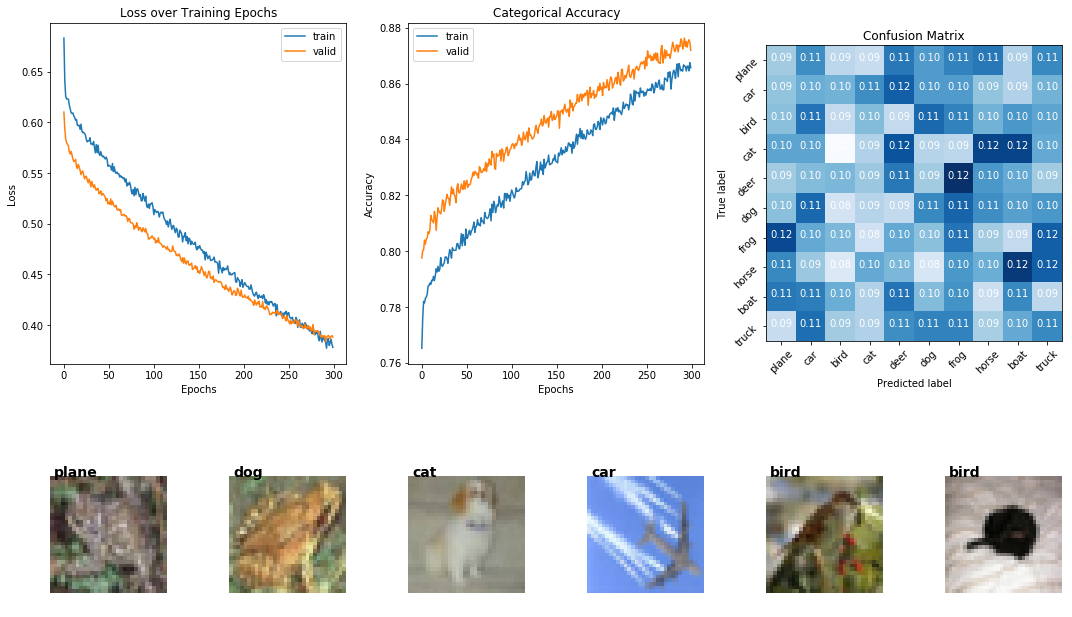

In [35]:
# Generate Predictions
y_pred = clr_model.predict_generator(test_datagen)

labels = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

class_names = list(labels.values())

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
dashboard(hist.history, cm=cnf_matrix, labels=class_names, y_pred=y_pred.argmax(1), test_data=(x_test, y_test.argmax(1)))

## Further Training: Comparing Optimizers
It seems like I can continue training the model. The loss has yet to flatten out, so I will load in the model and pick a new training routine to continue the training. From the pre-trained model, I will train the model with four different optimizers over a shorter training cycle and take a look at the convergence of each model.

In [83]:
from keras.models import load_model
clr_base = load_model('clr_model.h5')

In [105]:
# Create a model instance for each optimizer
loss = 'categorical_crossentropy'
metric = ['categorical_accuracy']

RMSprop = clr_base
Adagrad = clr_base
Adadelta = clr_base
Adam = clr_base

In [106]:
from CustomCallback import CyclicLR
from keras.models import load_model

# parameter settings
num_train = x_train.shape[0]
num_epochs = 30
batch_size = 500
iters_per_epoch = num_train // batch_size

# Flow training data through pre-processing pipeline
train_datagen = data.flow(x_train, y_train, batch_size=batch_size)
valid_datagen = data.flow(x_valid, y_valid, batch_size=batch_size)
test_datagen = data.flow(x_test, batch_size=batch_size)

hist = {}

# Fit the model
for optimizer, mdl in zip(['RMSprop', 'Adagrad', 'Adadelta', 'Adam'],
                          [RMSprop,    Adagrad,   Adadelta,   Adam]):
    
    mdl.compile(loss=loss, optimizer=optimizer, metrics=metric)
    
    # Learning rate Scheduler
    clr = CyclicLR(base_lr=0.0005, 
                   max_lr=0.008, 
                   step_size=4 * iters_per_epoch, 
                   mode='triangular')
    
    training = mdl.fit_generator(train_datagen,
                                   epochs=num_epochs,
                                   validation_data=valid_datagen,
                                   callbacks=[clr],
                                   shuffle=True,
                                   verbose=0)
    
    # Add training history
    hist[optimizer] = training.history
    
    # Add callback history
    hist[optimizer]['clr'] = clr.history
    

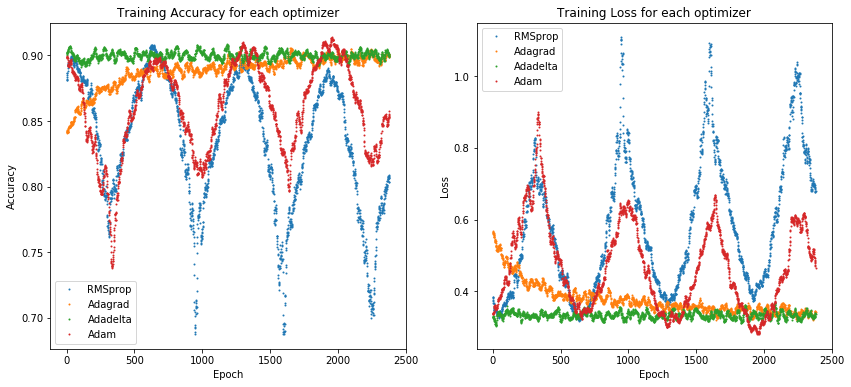

In [113]:
# For smoothing out learning history
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Plot history
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].set_title('Training Accuracy for each optimizer')
axs[1].set_title('Training Loss for each optimizer')

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Loss')

for optimizer, history in hist.items():
    axs[0].plot(moving_average(history['clr']['categorical_accuracy']), 
                'o', markersize=1, label=optimizer)
    axs[1].plot(moving_average(history['clr']['loss']), 
                'o', markersize=1, label=optimizer)
    
axs[0].legend()
axs[1].legend()
plt.show()

In [121]:
test_datagen = data.flow(x_test, y_test, batch_size=300)
print('Final Model: CNN\n\t'
      'Initial Training with SGD and a Cycle Learning Rate Schedule\n\t'
      'Final Training with Adagrad.')
print('Validation \n\tloss: {}\n\taccuracy: {}'.format(*Adagrad.evaluate_generator(valid_datagen)))
print('Test data \n\tloss: {}\n\taccuracy: {}'.format(*Adagrad.evaluate_generator(test_datagen)))
Adagrad.save('Adagrad.h5')

Final Model: CNN
	Initial Training with SGD and a Cycle Learning Rate Schedule
	Final Training with Adagrad.
Validation 
	loss: 0.4735064014792442
	accuracy: 0.8693000018596649
Test data 
	loss: 0.8820400369167328
	accuracy: 0.7646000021696091


# Wrapping Up
There was a 10% drop in accuracy when moving from the validation set to the test set. This can be explored further; performing an analysis on the classes that were mislabeled and try to gain an intuition of what is causing the model to misclassify. There are also many other techniques to employ in order to improve the accuracy of the model. Here are some ideas not explored in this write-up:
 - **Weight Analysis:**
     - The initialization values of the weights can be adjusted. Perhaps a gaussian distribution or a different random pattern can be used for inistialization.
     - The gradients and weight values can be visualized and reviewed. What do the convolutional masks look like? There should be a somewhat distinct shape activation shown in the weight filters.
     - initializing the biases. Adding intitialization values to the biases can help out the Relu function. This makes sure the Relu functions are fine at the very beginning of training and allows for the gradients to propogate through the model properly.
 - **Model Architecture:**
     - Are Max Pooling Layers necessary? Perhaps increasing the stride from 1 to 2 and removing some pooling layers would make training more efficient
     - Incorporating Batch Normalization layers. This could improve the overall accuracy of the model by adding a bit of robustness against bad initialization parameters on the weights.
     - Incorporating leaky Relu (setting Relu to output a value slightly larger than zero instead of zero). This may reduce the phenomenon of vanishing gradients.
     - 
 - **Data Augmentation:**
     - The data can be further transformed to a more uniform distribution. PCA Whitening can be applied across samples, possibly helping prominent features of each class images stand out.
     - The data can be augmented by padding the images by a quarter length on all sides then taking a subset of the image. Some objects may not be perfectly centered, so this technique would place the object in different positions in the image and most likely lead to better prediction capabilities.
 - **Learning Optimization**
     - Adam was a good optimizer to pick, the model could be retrained from the beginning just using Adam. The parameters for Adam can be tuned, and the training callback can be built out to include the gradient and weight values at each epoch. Generally the ratio of the gradients (before being scaled by the learning rate!) to the weights should be about 1e-3. If it is lower than this, then the learning rate might be set too low (or visa versa).
     
Until next time!